In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.datasets
import sklearn.cluster
import sklearn.preprocessing
import sklearn.neural_network
import sklearn.linear_model
import sklearn.model_selection
import torch

In [2]:
df = pd.read_csv('data.csv')
df.head(10)

,Unnamed: 0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
0,X21.V1.791,135,190,229,223,192,125,55,-9,-33,...,-17,-15,-31,-77,-103,-127,-116,-83,-51,4
1,X15.V1.924,386,382,356,331,320,315,307,272,244,...,164,150,146,152,157,156,154,143,129,1
2,X8.V1.1,-32,-39,-47,-37,-32,-36,-57,-73,-85,...,57,64,48,19,-12,-30,-35,-35,-36,5
3,X16.V1.60,-105,-101,-96,-92,-89,-95,-102,-100,-87,...,-82,-81,-80,-77,-85,-77,-72,-69,-65,5
4,X20.V1.54,-9,-65,-98,-102,-78,-48,-16,0,-21,...,4,2,-12,-32,-41,-65,-83,-89,-73,5
5,X14.V1.56,55,28,18,16,16,19,25,40,52,...,-12,-31,-42,-54,-60,-64,-60,-56,-55,5
6,X3.V1.191,-55,-9,52,111,135,129,103,72,37,...,-125,-99,-79,-62,-41,-26,11,67,128,4
7,X11.V1.273,1,-2,-8,-11,-12,-17,-15,-16,-18,...,-79,-91,-97,-88,-76,-72,-66,-57,-39,2
8,X19.V1.874,-278,-246,-215,-191,-177,-167,-157,-139,-118,...,-400,-379,-336,-281,-226,-174,-125,-79,-40,1
9,X3.V1.491,8,15,13,3,-6,-8,-5,4,25,...,49,31,11,-5,-17,-19,-15,-15,-11,4


In [3]:
df.shape

(11500, 180)

In [4]:
df.columns

Index(['Unnamed: 0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9',
       ...
       'X170', 'X171', 'X172', 'X173', 'X174', 'X175', 'X176', 'X177', 'X178',
       'y'],
      dtype='object', length=180)

In [5]:
Y_temp=df['y']
df = df.drop(['y','Unnamed: 0'], axis = 1)


# Epiléptico es 1 vs el resto de clases, las cuales que son 1,2,3,4,5

In [8]:
Y=np.where(Y_temp > 1, 0,1)
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(df, Y, test_size=0.3)

In [9]:
scaler = sklearn.preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [29]:
model = torch.nn.Sequential(
    torch.nn.Conv1d(1, 10, kernel_size=14, stride=1),
    torch.nn.MaxPool1d(kernel_size=3),
    torch.nn.Conv1d(10, 1, kernel_size=2, stride=1),
    torch.nn.Linear(54, 2)
)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.02) #lr: learning rate
epochs = 100
loss_values = np.zeros(epochs)
F1_values_train = np.zeros(epochs)
F1_values_test = np.zeros(epochs)


for epoch in range(epochs):
    X_new = np.expand_dims(X_train, 1) 
    inputs = torch.autograd.Variable(torch.Tensor(X_new).float())
    targets = torch.autograd.Variable(torch.Tensor(Y_train).long())
    
    optimizer.zero_grad()
    out = model(inputs)
    out = out.squeeze(dim=1) # necesario para quitar la dimension intermedia de channel
    loss = criterion(out, targets)
    loss.backward()
    optimizer.step()
    
    values, Y_predicted = torch.max(out.data, 1)
    loss_values[epoch] = loss.item()
    F1_values_train[epoch] = sklearn.metrics.f1_score(Y_train, Y_predicted, average='macro')
    
    X_new = np.expand_dims(X_test, 1)
    inputs_test = torch.autograd.Variable(torch.Tensor(X_new).float())
    out_test = model(inputs_test)
    out_test = out_test.squeeze(dim=1)
    values, Y_predicted_test = torch.max(out_test.data, 1)
    F1_values_test[epoch] = sklearn.metrics.f1_score(Y_test, Y_predicted_test, average='macro')

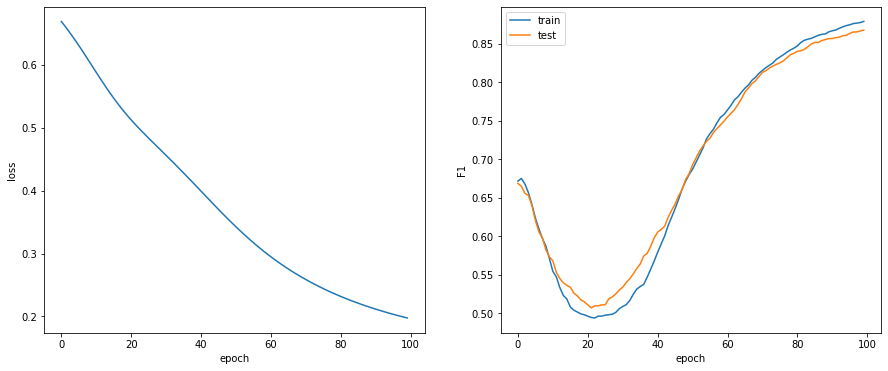

In [30]:
fig=plt.figure(figsize=(15, 6)) 
ax1=plt.subplot(1,2,1)
ax1.plot(np.arange(epochs), loss_values)
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')


ax2=plt.subplot(1,2,2)
ax2.plot(np.arange(epochs), F1_values_train, label='train')
ax2.plot(np.arange(epochs), F1_values_test, label='test')
ax2.set_xlabel('epoch')
ax2.set_ylabel('F1')
ax2.legend()